<a href="https://colab.research.google.com/github/blackleg-sanji007/Analysis-and-Comparison-ML-models-for-Fair-Price-Prediction-of-Options-/blob/main/Analysis_and_Comparison_ML_models_for_Fair_Price_Prediction_of_Options.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from google.colab import files
np.random.seed(42)

This function takes inputs:

1. S: Spot price

2. K: Strike price
3. T: Time to maturity (in years)

4. r: Risk-free interest rate (decimal, e.g., 0.03)

5. sigma: Volatility (decimal)

6. option_type: "call" or "put"

In [ ]:
def simulate_gbm(S0, r, sigma, T, steps=252):
    steps = int(T*252*6)
    dt = T / steps
    rand = np.random.normal(0, 1, steps)
    prices = [S0]
    for z in rand:
        S_next = prices[-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
        prices.append(S_next)
    return prices

In [ ]:
def monte_carlo_price(S0, strike, sigma, r, T, n_paths=1000):
    payoffs = []
    for _ in range(n_paths):
        path = simulate_gbm(S0, r, sigma, T)
        S_T = path[-1]
        payoff = max(S_T - strike, 0)  # for call option
        payoffs.append(payoff)
    expected_payoff = np.mean(payoffs)
    return expected_payoff * np.exp(-r * T)


In [ ]:
def generate_dataset(n_samples=1000, n_paths=100):
    var = []
    fair_price = []

    for _ in range(n_samples):
        S = np.random.uniform(50, 150)
        a = np.random.randint(-10, 11)  # percent away from spot
        strike = S * (1 + a / 100)
        strike = round(strike / 50) * 50

        sigma = np.random.uniform(0.1, 0.6)
        r = 0.05
        T = np.random.randint(1, 252)/252

        price = monte_carlo_price(S, strike, sigma, r, T, n_paths)

        var.append([S, strike, sigma, r, T])
        fair_price.append(price)

    return np.array(var), np.array(fair_price)

In [ ]:
x,y = generate_dataset()

In [ ]:
print(len(y))
print(len(x))
print(pd.DataFrame(x).head())
print(pd.DataFrame(y).head())

1000
1000
            0      1         2     3         4
0  104.086295  100.0  0.256904  0.05  0.619048
1   73.744763   50.0  0.534354  0.05  0.944444
2  125.913727  150.0  0.306084  0.05  0.964286
3  125.385577  150.0  0.143768  0.05  0.793651
4  143.625601  150.0  0.513767  0.05  0.511905
           0
0  13.477655
1  32.912916
2   5.632726
3   1.882664
4  21.203438


In [ ]:
columns = ['spot_price', 'strike_price', 'volatility', 'interest_rate', 'time_to_expiry']
df = pd.DataFrame(x, columns=columns)
df['option_price'] = y
df["option_price"] = df["option_price"].astype(float)

df.to_csv('synthetic_option_data_copy.csv', index=False)



# Linear Reggression Implimentation

In [ ]:
from sklearn.model_selection import train_test_split

x = df.drop('option_price', axis = 1)
y = df["option_price"].values.reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2 , random_state= 42)


In [ ]:
from sklearn.linear_model import LinearRegression

lr  = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = lr.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
r2  = r2_score(y_test,y_pred)

print("Linear Reggrssion RMSE:" , rmse)
print("Linear Reggression R_square:", r2)

Linear Reggrssion RMSE: 4.1800554706150175
Linear Reggression R_square: 0.8029699749165488


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

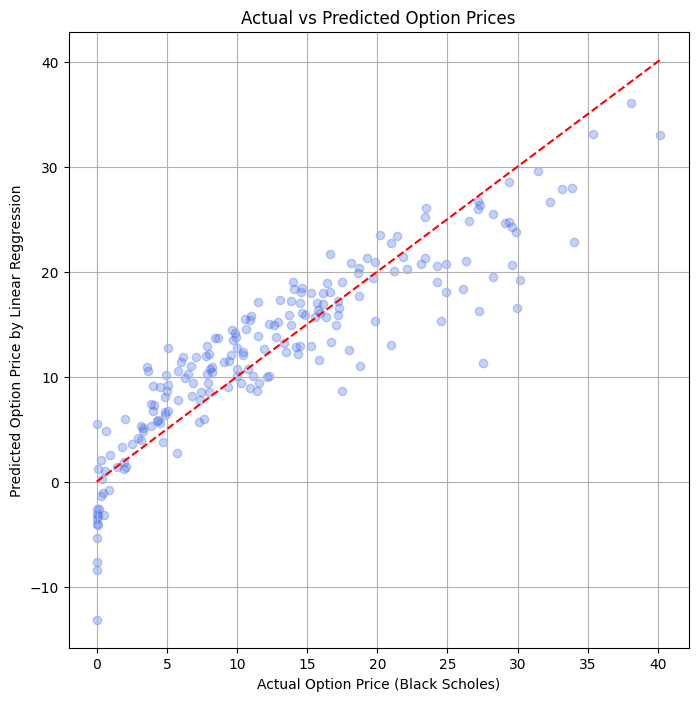

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8,8))
plt.scatter(y_test, y_pred, alpha =  0.3, color = 'royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # y = x line
plt.xlabel("Actual Option Price (Black Scholes)")
plt.ylabel("Predicted Option Price by Linear Reggression")
plt.title("Actual vs Predicted Option Prices")

plt.grid(True)
plt

# XGBoost


In [ ]:
pip install xgboost

In [ ]:
from xgboost import XGBRegressor
xgb = XGBRegressor(
    n_estimators = 100,
    learning_rate = 0.1,
    max_depth = 5,
    random_state = 42
)

xgb.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_pred_xgb = xgb.predict(x_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
print("XGBoost RMSE:", rmse_xgb)
print("XGBoost R_square:", r2_xgb)

XGBoost RMSE: 2.7722206381053787
XGBoost R_square: 0.9133389578712705


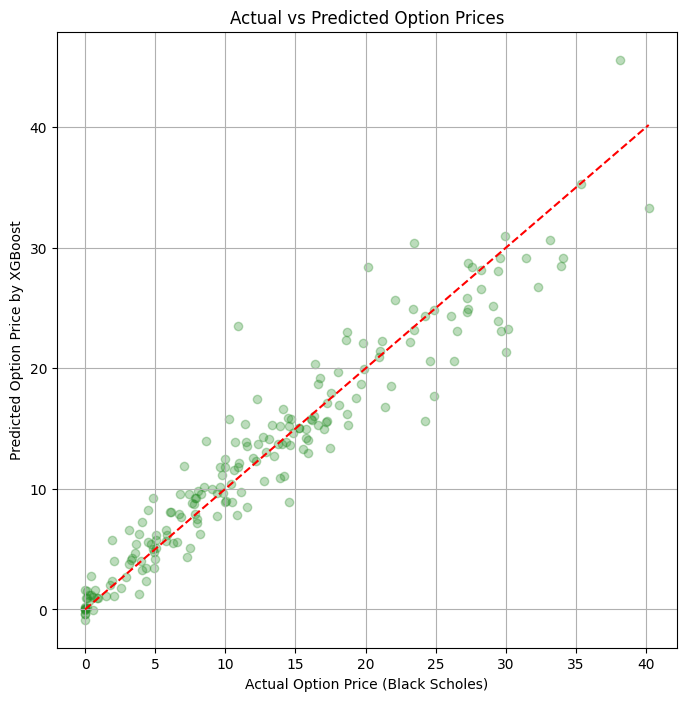

In [ ]:
plt.figure(figsize = (8,8))
plt.scatter(y_test, y_pred_xgb, alpha = 0.3, color = 'forestgreen') # Add quotes around 'forestgreen'
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

plt.xlabel("Actual Option Price (Black Scholes)")
plt.ylabel("Predicted Option Price by XGBoost")
plt.title("Actual vs Predicted Option Prices")

plt.grid(True)
plt.show()

# Using MLP

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch.optim as optim


In [ ]:
X = df.drop('option_price', axis = 1).values
Y = df['option_price'].values.reshape(-1,1)

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_Y = StandardScaler()
Y_scaled = scaler_Y.fit_transform(Y)

X_tensor = torch.tensor(X_scaled, dtype = torch.float32)
Y_tensor = torch.tensor(Y_scaled, dtype = torch.float32)




In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_tensor, Y_tensor, test_size = 0.2, random_state = 42)

train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [ ]:


class OptionMLP(nn.Module):
    def __init__(self, input_dim):
        super(OptionMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.LeakyReLU(),

            nn.Linear(32, 1),
            # nn.ReLU()  # ← optional if not scaling output
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
model = OptionMLP(input_dim = X.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 50)

epochs = 100
for epoch in range(epochs):
  model.train()
  total_loss = 0
  for xb, yb in train_loader:
    optimizer.zero_grad()
    pred = model(xb)
    loss = criterion(pred, yb)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  scheduler.step()
  if(epoch + 1) % 10 == 0:
    print(f"Epoch {epoch +1}, Loss: {total_loss / len(train_loader): 0.6f}")



Epoch 10, Loss:  0.199800
Epoch 20, Loss:  0.114482
Epoch 30, Loss:  0.137418
Epoch 40, Loss:  0.115588
Epoch 50, Loss:  0.143135
Epoch 60, Loss:  0.119248
Epoch 70, Loss:  0.103033
Epoch 80, Loss:  0.122914
Epoch 90, Loss:  0.137716
Epoch 100, Loss:  0.116240


In [ ]:
model.eval()
with torch.no_grad():
  preds_scaled = model(X_test).detach().numpy()
  preds = scaler_Y.inverse_transform(preds_scaled)
  true = scaler_Y.inverse_transform(Y_test)

  rmse_MLP = np.sqrt(mean_squared_error(true, preds))
  r2_MLP = r2_score(true, preds)

print("MLP RMSE:", rmse_MLP)
print("MLP R_square:", r2_MLP)

MLP RMSE: 2.4414454073756375
MLP R_square: 0.9327855952976079


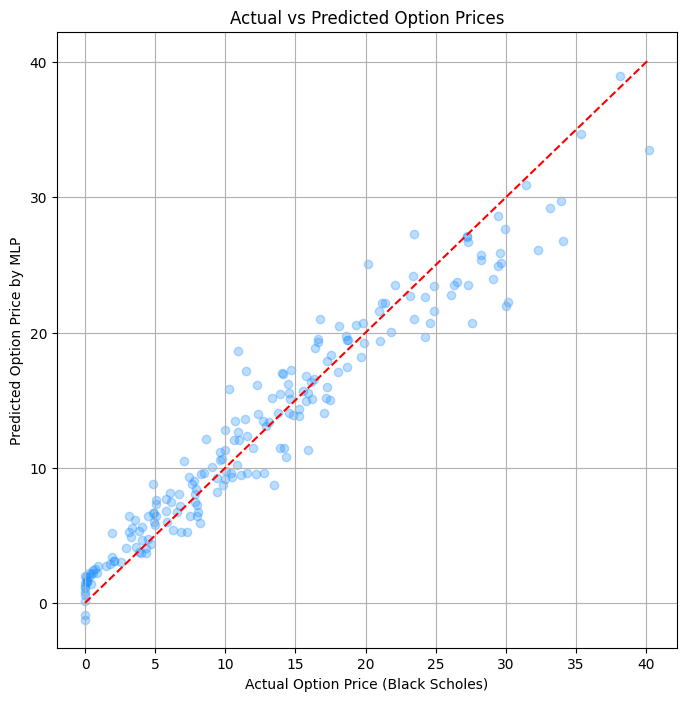

In [ ]:
plt.figure(figsize= (8,8))
plt.scatter(true, preds, alpha = 0.3, color = 'dodgerblue')
plt.plot([true.min(), true.max()], [true.min(), true.max()], 'r--')

plt.xlabel("Actual Option Price (Black Scholes)")
plt.ylabel("Predicted Option Price by MLP")
plt.title("Actual vs Predicted Option Prices")

plt.grid(True)
plt.show()

In [ ]:
import numpy as np
from scipy.stats import norm

def black_scholes_call(S, K, sigma, r, T):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price


In [ ]:

# Columns assumed: 'spot', 'strike', 'sigma', 'r', 'T'
bsm_prices = black_scholes_call(
    S=df["spot_price"],
    K=df["strike_price"],
    sigma=df["volatility"],
    r=df["interest_rate"],
    T=df["time_to_expiry"]
)

df["bsm_price"] = bsm_prices


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

mse = mean_squared_error(df["option_price"], df["bsm_price"])
rmse_bsm = np.sqrt(mse)
r2_bsm = r2_score(df["option_price"], df["bsm_price"])

print(f"BSM RMSE: {rmse_bsm:.4f}")
print(f"BSM R²: {r2_bsm:.4f}")


BSM RMSE: 2.0579
BSM R²: 0.9501


In [ ]:
!pip install qfin

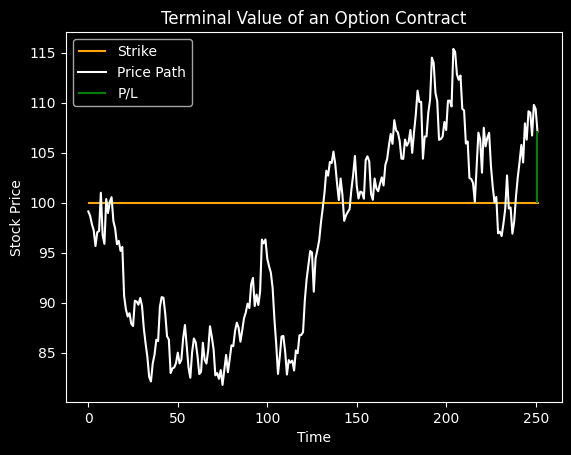

Premium at t=0: 16.657576458042556
MLP Prediction 7.268290042877197
Terminal Value: 107.11151087625858
Strike Price: 100
P/L MLP: -0.15677916661861957
P/L: -9.546065581783978


In [ ]:
import matplotlib.pyplot as plt
import qfin as qf

# simulate dynamics of the underlying according to Geometric Brownian Motion
S = np.random.uniform(50, 150)
a = np.random.randint(-10, 11)  # percent away from spot
St = S * (1 + a / 100)
St = round(St / 50) * 50
path = qf.simulations.GeometricBrownianMotion(S, 0.05, .3, 1/252, 1)


features = torch.tensor([[S, St, 0.3, 0.05, 1.0]], dtype=torch.float32)
model.eval()
with torch.no_grad():
    mlp_price = model(features).item()

# create a chart of the price path and the strike price
expiry_step = len(path.simulated_path) -1
plt.title("Terminal Value of an Option Contract")
plt.hlines(St, 0, 252, label='Strike', color='orange')
plt.plot(path.simulated_path, label='Price Path', color='white')
plt.vlines(expiry_step,
           min(path.simulated_path[-1], St),
           max(path.simulated_path[-1], St),
           color='green' if path.simulated_path[-1] > St else 'red',
           label="P/L")
plt.style.use('dark_background')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# print the premium and the resulting P/L
print("Premium at t=0:", black_scholes_call(S, St, .3, .05, 1))
print("MLP Prediction", mlp_price)
print("Terminal Value:", path.simulated_path[-1])
print("Strike Price:", St)
print("P/L MLP:", max(path.simulated_path[-1] - St, 0) - mlp_price)
print("P/L:", max(path.simulated_path[-1] - St, 0) - black_scholes_call(S, St, .3, .05, 1))

In [ ]:
features = torch.tensor([[100,100, 0.3, 0.05, 1.0]], dtype=torch.float32)
model.eval()
with torch.no_grad():
    mlp_price = model(features).item()


print("Market Maker Quote:", "13.43 @ 14.10")
print("Call Price:", black_scholes_call(100, 100, .3, .05, 1))
print("Call Price MLP:", mlp_price )
print("Trade Edge:", black_scholes_call(100, 100, .3, .05, 1) - 14.10)
print("Trade Edge MLP:", mlp_price - 14.10)

Market Maker Quote: 13.43 @ 14.10
Call Price: 14.231254785985819
Call Price MLP: 2.281097650527954
Trade Edge: 0.13125478598581886
Trade Edge MLP: -11.818902349472046


In [ ]:
premium = 14.10 * 100
pls = []
pls_mlp = []
for i in range(100000):
    path = qf.simulations.GeometricBrownianMotion(100, 0.05, .3, 1/252, 1)
    pls.append(max(path.simulated_path[-1] - 100, 0)*100 - premium)

np.mean(pls)

np.float64(90.53477891793688)

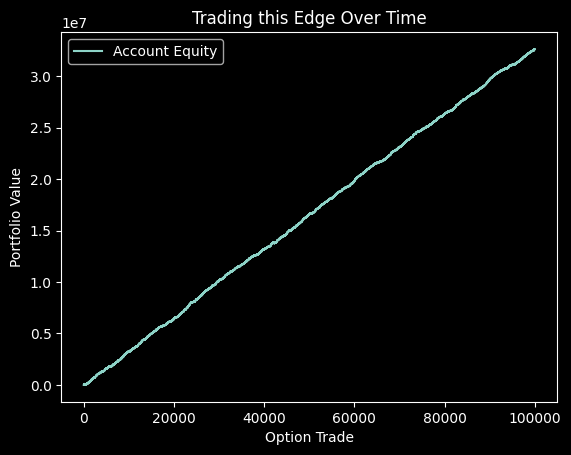

In [ ]:
premium = 14.10 * 100
pls = []

S = np.random.uniform(50, 150)
a = np.random.randint(-10, 11)  # percent away from spot
St = S * (1 + a / 100)
St = round(St / 50) * 50

for i in range(100000):
    path = qf.simulations.GeometricBrownianMotion(S, 0.05, .3, 1/252, 1)
    pls.append(max(path.simulated_path[-1] - St, 0)*100 - premium)

plt.title("Trading this Edge Over Time")
plt.plot(np.cumsum(pls), label="Account Equity")
plt.style.use('dark_background')
plt.xlabel('Option Trade')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()